# fsLR-5k MPC multi-acq

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)


# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

    
# Load files
def make_mpc5k(files):
    # Load all the matrices
    Ndim=9684
    M=np.empty([Ndim, Ndim, len(files)], dtype=float)
    for i, f in enumerate(files):
        print(f)
        int_profile = nb.load(f).darrays[0].data
        M[:,:,i] = build_mpc(smooth_intensities(int_profile), mask_surf)

    return M

## Create a brain mask derived from the thickness

/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


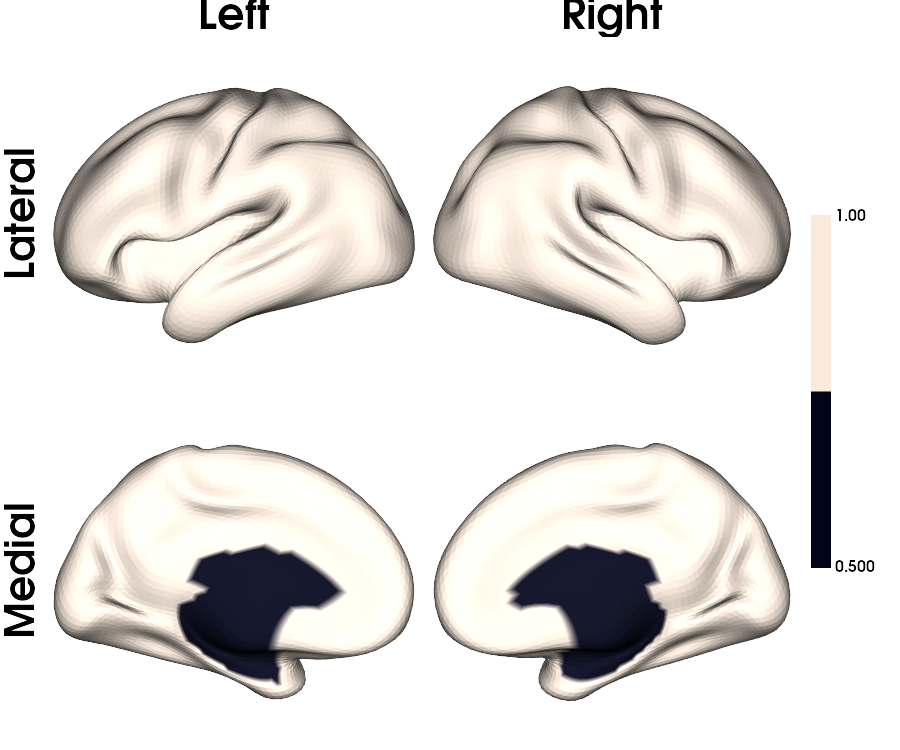

In [8]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

mask_surf = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_surf, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)


# MPC-T1map from intensitites

In [32]:
# -----------------------------------------------------------------------------
# All subjects 
# MPC files of Authism spectrum Disorder
files_all = sorted(glob.glob('sub-*/ses-01/mpc/acq-T1map/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii'))

# make the MPC
mpc_all = make_mpc5k(files_all)

# Mean matrix across the z axis (subjects)
mpc_all_avg = np.mean(mpc_all, axis=2)


/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


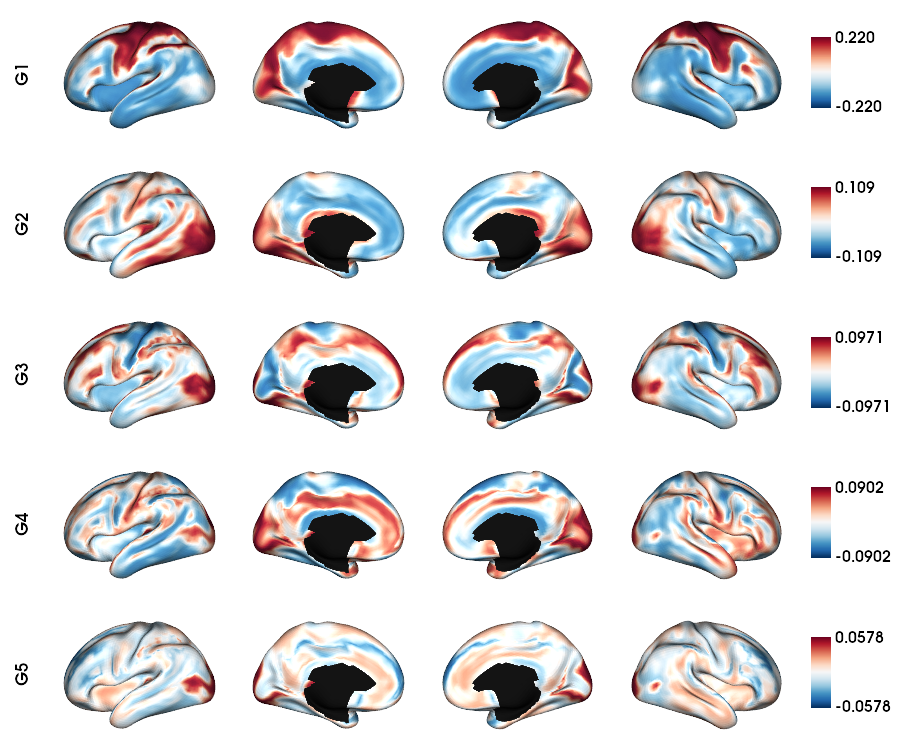

In [11]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(mpc_all_avg, mask_surf, Ngrad=Ngrad, Smooth=False)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False,
  filename='/home/bic/rcruces/Desktop/MPC_PNC_3G.png')


# MPC-T1map G1

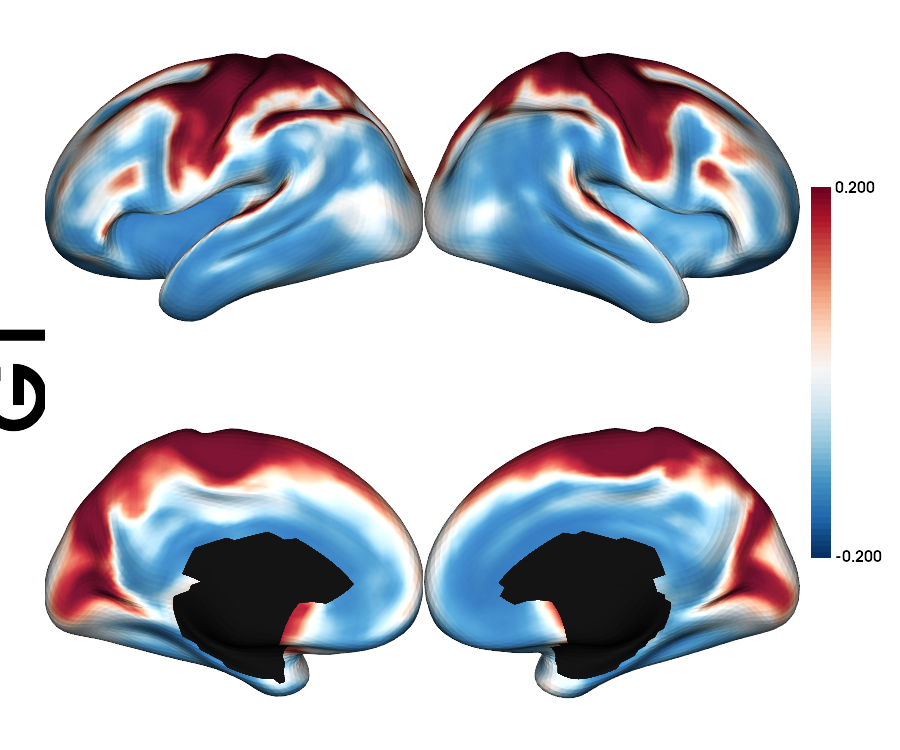

In [17]:
# Group G1 
G1 = grad[0]
plot_hemispheres(inf_lh, inf_rh, array_name=G1, cmap='RdBu_r',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid', color_range=(-0.2, 0.2),
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1),
                  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_ALL_G1.png')


# MPC-MTR from intensitites

In [19]:
# MPC files of MTR
files_all = sorted(glob.glob('sub-*/ses-03/mpc/acq-MTR/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii'))

# make the MPC
mpc_all = make_mpc5k(files_all)

# Mean matrix across the z axis (subjects)
mpc_all_avg = np.mean(mpc_all, axis=2)


sub-PNC002/ses-03/mpc/acq-MTR/sub-PNC002_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_36919/2138095095.py:87: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


sub-PNC003/ses-03/mpc/acq-MTR/sub-PNC003_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC006/ses-03/mpc/acq-MTR/sub-PNC006_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC007/ses-03/mpc/acq-MTR/sub-PNC007_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC009/ses-03/mpc/acq-MTR/sub-PNC009_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC010/ses-03/mpc/acq-MTR/sub-PNC010_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC016/ses-03/mpc/acq-MTR/sub-PNC016_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC018/ses-03/mpc/acq-MTR/sub-PNC018_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC019/ses-03/mpc/acq-MTR/sub-PNC019_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii


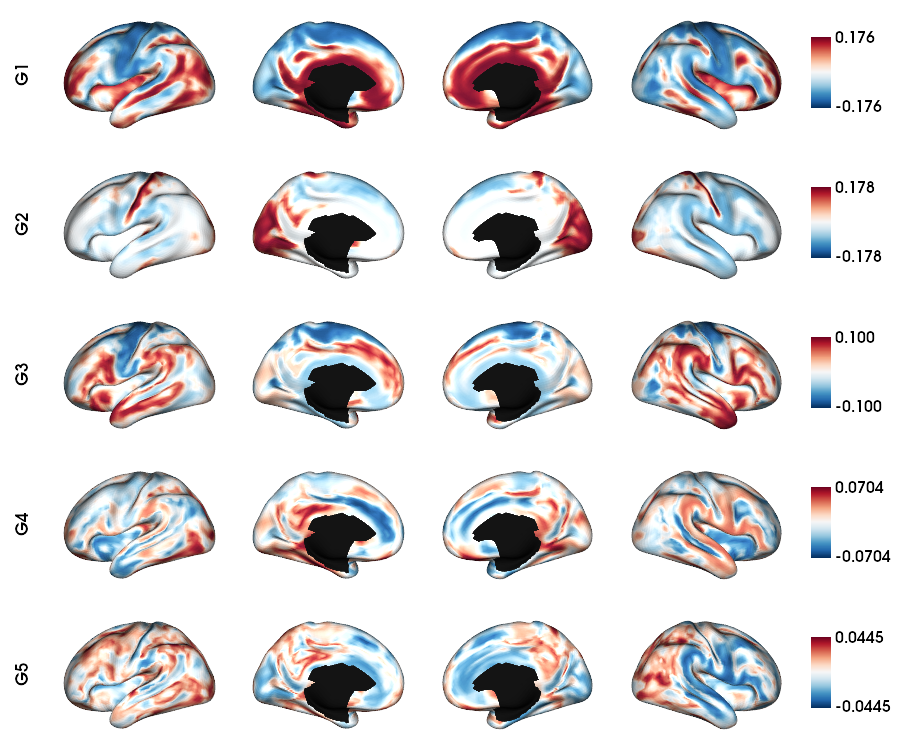

In [21]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(mpc_all_avg, mask_surf, Ngrad=Ngrad, Smooth=False)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False,
  filename='/home/bic/rcruces/Desktop/MPC_PNC_3G.png')

# MPC-MTR G2

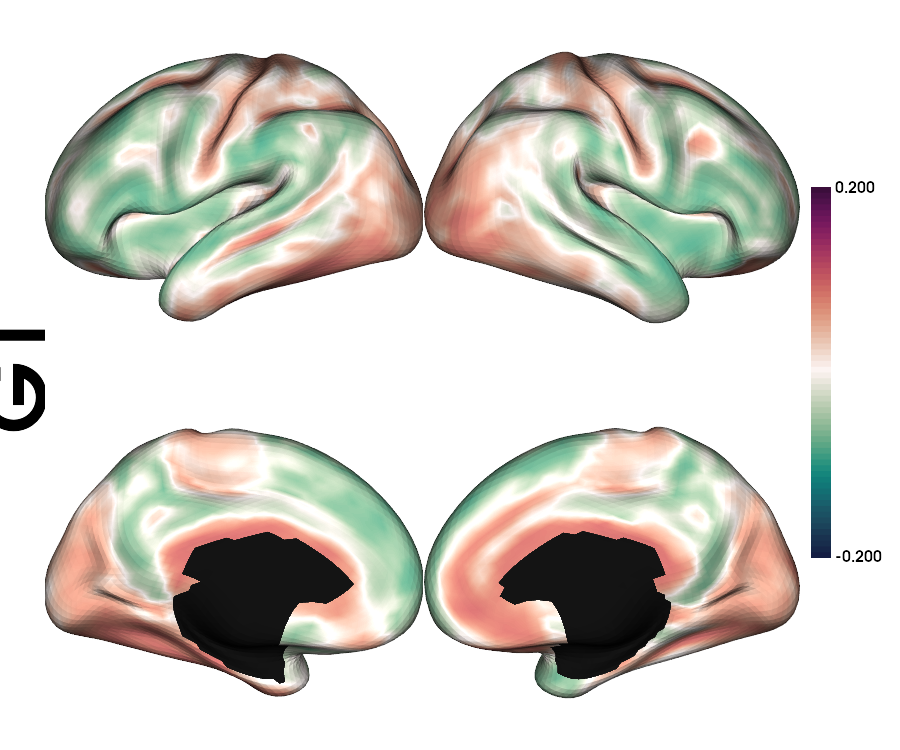

In [29]:
# Group G2
G1 = grad[1]
plot_hemispheres(inf_lh, inf_rh, array_name=G1, cmap='cmo.curl',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid', color_range=(-0.2, 0.2),
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1),
                  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_ALL_G1.png')


# MPC - MTSAT from intensities

In [23]:
# MPC files of MTSAT
files_all = sorted(glob.glob('sub-*/ses-03/mpc/acq-MTSAT/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii'))

# make the MPC
mpc_all = make_mpc5k(files_all)

# Mean matrix across the z axis (subjects)
mpc_all_avg = np.mean(mpc_all, axis=2)


sub-PNC002/ses-03/mpc/acq-MTSAT/sub-PNC002_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_36919/2138095095.py:87: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


sub-PNC003/ses-03/mpc/acq-MTSAT/sub-PNC003_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC006/ses-03/mpc/acq-MTSAT/sub-PNC006_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC007/ses-03/mpc/acq-MTSAT/sub-PNC007_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC009/ses-03/mpc/acq-MTSAT/sub-PNC009_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC010/ses-03/mpc/acq-MTSAT/sub-PNC010_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC016/ses-03/mpc/acq-MTSAT/sub-PNC016_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC018/ses-03/mpc/acq-MTSAT/sub-PNC018_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC019/ses-03/mpc/acq-MTSAT/sub-PNC019_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii


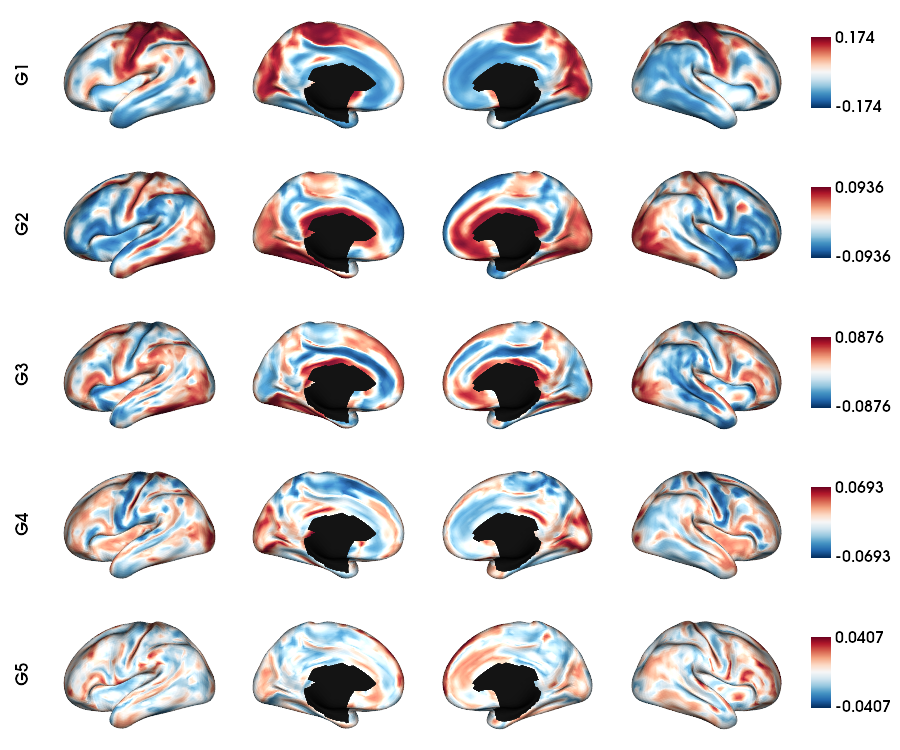

In [24]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(mpc_all_avg, mask_surf, Ngrad=Ngrad, Smooth=False)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False,
  filename='/home/bic/rcruces/Desktop/MPC_PNC-MTSAT_3G.png')

# MPC- MTSAT G1

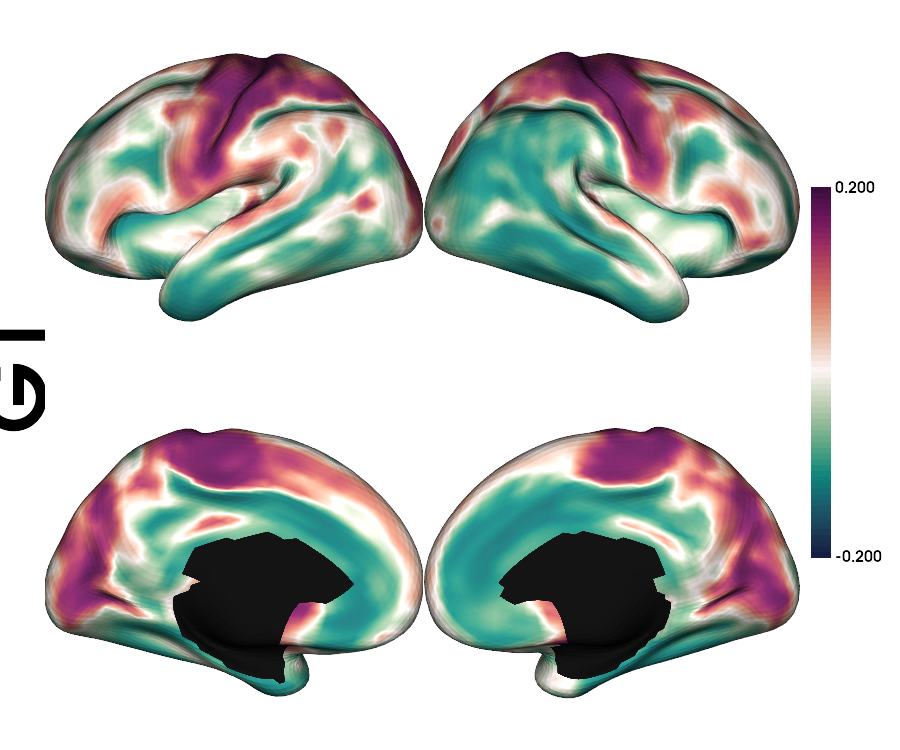

In [31]:
import cmocean
cmaps = cmocean.cm.cmap_d

# Group G2
G1 = grad[0]
plot_hemispheres(inf_lh, inf_rh, array_name=G1, cmap='cmo.curl',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid', color_range=(-0.2, 0.2),
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1),
                  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC-MTSAT_G1.png')


# Check the `normalized_angle` kernel, what happends to negative values?

# fsLR-32k qMRI maps 

In [68]:
# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

In [84]:
def load_qmri_group(qmri=''):
    '''
    This function loads and plots the qMRI intensity maps on fsLR32k midthickness
    '''
    # List the files
    files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-midthickness_{qmri}.func.gii"))
    files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-midthickness_{qmri}.func.gii"))

    # Load all the thickness data
    Nqmri=np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

    surf_map=np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i,:] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
    N = surf_map.shape[0]
    print(f"Numer of {qmri} maps: {N}")               
    return(map_mean,surf_map)

def plot_qmri_int(qmri='', midwall_mask=False, cmap='rocket', horiz=False, rq=(0.01, 0.99)):
    map_mean,_ = load_qmri_group(qmri)
    
    # Plot the group T1map intensitites
    crange=(np.quantile(map_mean[mask_32k], rq[0]), np.quantile(map_mean[mask_32k], rq[1]))

    # Replace values in f with NaN where mask_32k is False
    if midwall_mask == True: map_mean[mask_32k == False] = np.nan
    
    if horiz == True:
        fig = plot_hemispheres(inf32_lh, inf32_rh, array_name=map_mean, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), cmap=cmap, color_range=crange, transparent_bg=False, screenshot = False)

    else:
        fig = plot_hemispheres(inf32_lh, inf32_rh, array_name=map_mean, cmap=cmap, nan_color=(0, 0, 0, 1),
                  zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', layout_style='grid', color_range=crange,
                  label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)
    return(fig)

Numer of T1map maps: 42


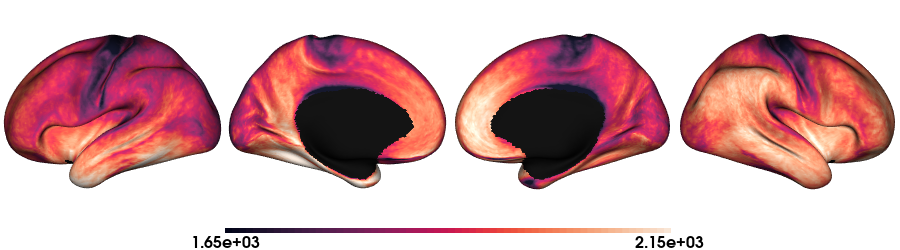

In [86]:
plot_qmri_int(qmri='T1map', midwall_mask=True, cmap='rocket', horiz=True)

Numer of MTR maps: 10


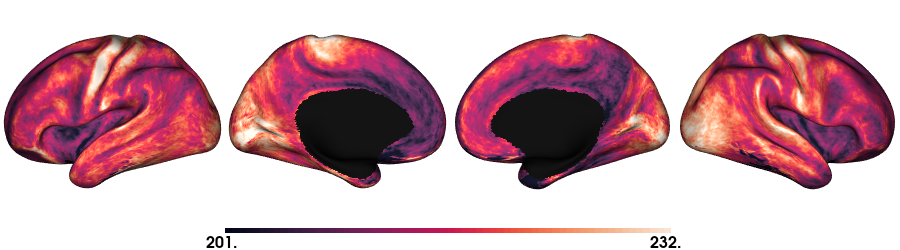

In [87]:
plot_qmri_int(qmri='MTR', midwall_mask=True, cmap='rocket', horiz = True)

Numer of MTSAT maps: 10


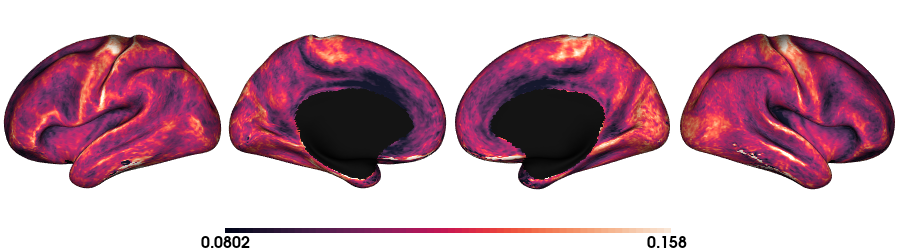

In [88]:
plot_qmri_int(qmri='MTSAT', midwall_mask=True, cmap='rocket', horiz = True)

Numer of ADC maps: 33


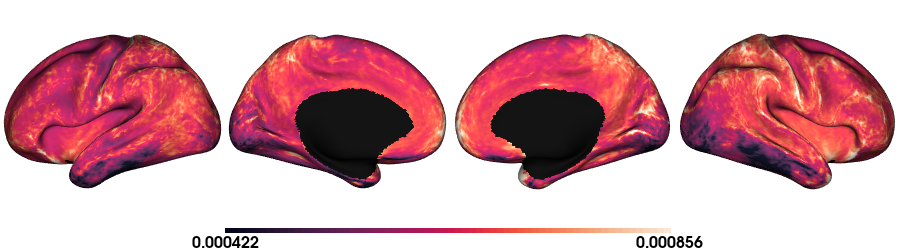

In [89]:
plot_qmri_int(qmri='ADC', midwall_mask=True, cmap='rocket', horiz = True)

# fsLR-5k | MPC - T1map

ValueError: Affinity matrix contains NaN or Inf values. Common causes of this include NaNs/Infs or rows of zeros in the input matrix.

In [ ]:
# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in lh_files]

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
        #print(f)
        surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
        
        